In [1]:
import jax
import numpy as np
import matplotlib.pyplot as plt
from jax.flatten_util import ravel_pytree
import jax.numpy as jnp
import matplotlib.gridspec as gridspec
import sys
import os

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

import piml_library.hamiltonian as ham

In [2]:
# 0~9: 内挿 (Interpolation) -> 平均に含める
# 10~12: 外挿 (Extrapolation) -> 平均には含めず、個別に表示する
N_interp = 10

In [3]:
@jax.jit
#H((t, q, p))
def H_analytical(q, p , m=1.0, k=1.0):
    q_flat, _ = ravel_pytree(q) 
    p_flat, _ = ravel_pytree(p) 
    
    T = 0.5 / m * jnp.sum(p_flat**2) 
    V = 0.5 * k * jnp.sum(q_flat**2) 
    return T + V 

In [4]:
# MSEの計算
# MSE = ((q - q_t)^2 + (p - p_t)^2) / 2
# Shape: (10, T, D) -> mean(axis=2) -> (10, T)
def calc_mse_traj(q_pred, p_pred, q_ref, p_ref):
    sq_err_q = (q_pred - q_ref)**2
    sq_err_p = (p_pred - p_ref)**2
 
    mse = (sq_err_q + sq_err_p) / 2.0
    if mse.ndim == 3:
        mse = np.mean(mse, axis=2)
    return mse # (10, T)

In [5]:
# 相対誤差の計算 (平均化しない版)
def calc_relative_energy_error_traj(E_pred, E_true):
    """
    平均をとらず、軌道ごとの相対誤差 (N, T) を返す
    """
    epsilon = 1e-10
    return np.abs((E_pred - E_true) / (np.abs(E_true) + epsilon))

In [6]:
def prepare_for_jax(arr):
    # (N, T) -> (N, T, 1)
    if arr.ndim == 2:
        return arr[..., None]
    return arr

In [7]:
# エネルギー相対誤差の平均を計算
# 定義: |E_pred - E_true| / |E_true| を計算し、10軌道で平均する

def calc_mean_relative_energy_error(E_pred, E_true):
    # E_pred, E_true shape: (10, T)
    # ゼロ除算防止のための微小項
    epsilon = 1e-10
    
    # 各軌道ごとの相対誤差 (10, T)
    rel_error = np.abs((E_pred - E_true) / (np.abs(E_true) + epsilon))
    
    # 軌道方向(axis=0)で平均 -> (T,)
    return np.mean(rel_error, axis=0)

In [8]:
# --- 保存したデータをロード ---
data_lnn = np.load("results_H1D_LNN.npz")
data_hnn = np.load("results_H1D_HNN.npz")
data_bnn_h = np.load("results_H1D_NN_h.npz")
data_bnn_l = np.load("results_H1D_NN_l.npz")

# HNNファイルに含まれる True Data を基準として使用する
t_eval = data_hnn['t_true_hnn'][0] 
q_true = data_hnn['q_true_hnn']
v_true = data_hnn['v_true_hnn']
p_true = data_hnn['p_true_hnn']

# --- HNNのデータを展開 ---
q_hnn = data_hnn['q_learned_hnn']
v_hnn = data_hnn['v_learned_hnn']
p_hnn = data_hnn['p_learned_hnn']

q_lnn_from_hnn = data_hnn['q_learned_lnn_from_hnn']
v_lnn_from_hnn = data_hnn['v_learned_lnn_from_hnn']
p_lnn_from_hnn = data_hnn['p_learned_lnn_from_hnn']

# --- LNNのデータを展開 ---
q_lnn = data_lnn['q_learned_lnn']
v_lnn = data_lnn['v_learned_lnn']
p_lnn = data_lnn['p_learned_lnn']

q_hnn_from_lnn = data_lnn['q_learned_hnn_from_lnn']
v_hnn_from_lnn = data_lnn['v_learned_hnn_from_lnn']
p_hnn_from_lnn = data_lnn['p_learned_hnn_from_lnn']

# --- BNNのデータを展開 ---
q_bnn_h = data_bnn_h['q_learned']
v_bnn_h = data_bnn_h['v_learned']
p_bnn_h = data_bnn_h['p_learned']

q_bnn_l = data_bnn_l['q_learned']
v_bnn_l = data_bnn_l['v_learned']
p_bnn_l = data_bnn_l['p_learned']

vmap_H = jax.vmap(jax.vmap(H_analytical, in_axes=(0, 0)), in_axes=(0, 0))

# 各モデルの全軌道MSE (10, T)
mse_hnn_traj = calc_mse_traj(q_hnn, p_hnn, q_true, p_true)
mse_lnn_from_hnn_traj = calc_mse_traj(q_lnn_from_hnn, p_lnn_from_hnn, q_true, p_true)
mse_lnn_traj = calc_mse_traj(q_lnn, p_lnn, q_true, p_true)
mse_hnn_from_lnn_traj = calc_mse_traj(q_hnn_from_lnn, p_hnn_from_lnn, q_true, p_true)
mse_bnn_h_traj = calc_mse_traj(q_bnn_h, p_bnn_h, q_true, p_true)
mse_bnn_l_traj = calc_mse_traj(q_bnn_l, p_bnn_l, q_true, p_true)

# True
E_true = vmap_H(prepare_for_jax(q_true), prepare_for_jax(p_true))
E_hnn = vmap_H(prepare_for_jax(q_hnn), prepare_for_jax(p_hnn))
E_lnn_from_hnn = vmap_H(prepare_for_jax(q_lnn_from_hnn), prepare_for_jax(p_lnn_from_hnn))
E_lnn = vmap_H(prepare_for_jax(q_lnn), prepare_for_jax(p_lnn))
E_hnn_from_lnn = vmap_H(prepare_for_jax(q_hnn_from_lnn), prepare_for_jax(p_hnn_from_lnn))
E_bnn_h = vmap_H(prepare_for_jax(q_bnn_h), prepare_for_jax(p_bnn_h))
E_bnn_l = vmap_H(prepare_for_jax(q_bnn_l), prepare_for_jax(p_bnn_l))

# 内挿データのMSEの計算
# 軌道方向 (axis=0) で平均をとる -> (T,)
mse_hnn_mean = np.mean(mse_hnn_traj[:N_interp], axis=0)
mse_lnn_from_hnn_mean = np.mean(mse_lnn_from_hnn_traj[:N_interp], axis=0)
mse_bnn_h_mean = np.mean(mse_bnn_h_traj[:N_interp], axis=0)

mse_lnn_mean = np.mean(mse_lnn_traj[:N_interp], axis=0)
mse_hnn_from_lnn_mean = np.mean(mse_hnn_from_lnn_traj[:N_interp], axis=0)
mse_bnn_l_mean = np.mean(mse_bnn_l_traj[:N_interp], axis=0)

# エネルギー相対誤差の計算 (全軌道分)
err_E_bnn_h = calc_relative_energy_error_traj(E_bnn_h, E_true)
err_E_hnn = calc_relative_energy_error_traj(E_hnn, E_true)
err_E_hnn_from_lnn = calc_relative_energy_error_traj(E_hnn_from_lnn, E_true)

err_E_bnn_l = calc_relative_energy_error_traj(E_bnn_l, E_true)
err_E_lnn = calc_relative_energy_error_traj(E_lnn, E_true)
err_E_lnn_from_hnn = calc_relative_energy_error_traj(E_lnn_from_hnn, E_true)

# 内挿データの平均値
err_energy_hnn = np.mean(err_E_hnn[:N_interp], axis=0)
err_energy_hnn_from_lnn = np.mean(err_E_hnn_from_lnn[:N_interp], axis=0)
err_energy_bnn_h = np.mean(err_E_bnn_h[:N_interp], axis=0)
err_energy_lnn = np.mean(err_E_lnn[:N_interp], axis=0)
err_energy_lnn_from_hnn = np.mean(err_E_lnn_from_hnn[:N_interp], axis=0)
err_energy_bnn_l = np.mean(err_E_bnn_l[:N_interp], axis=0)

<Figure size 1800x1500 with 0 Axes>

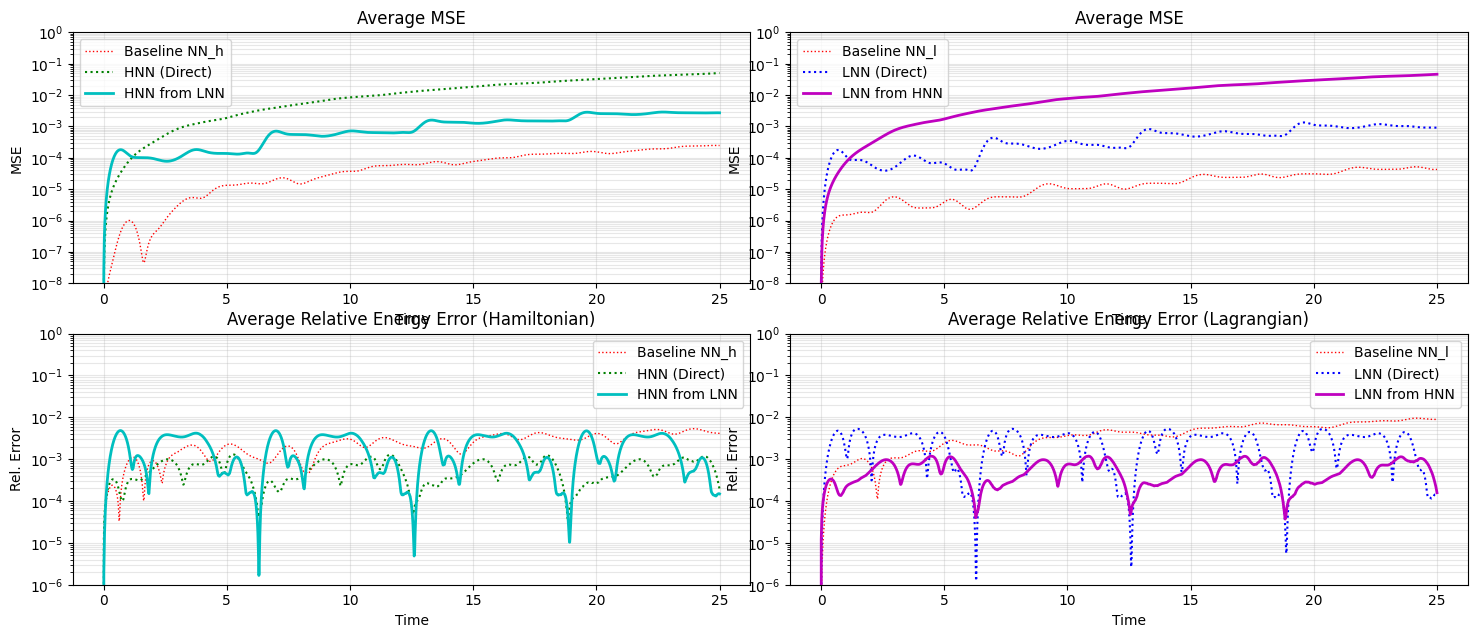

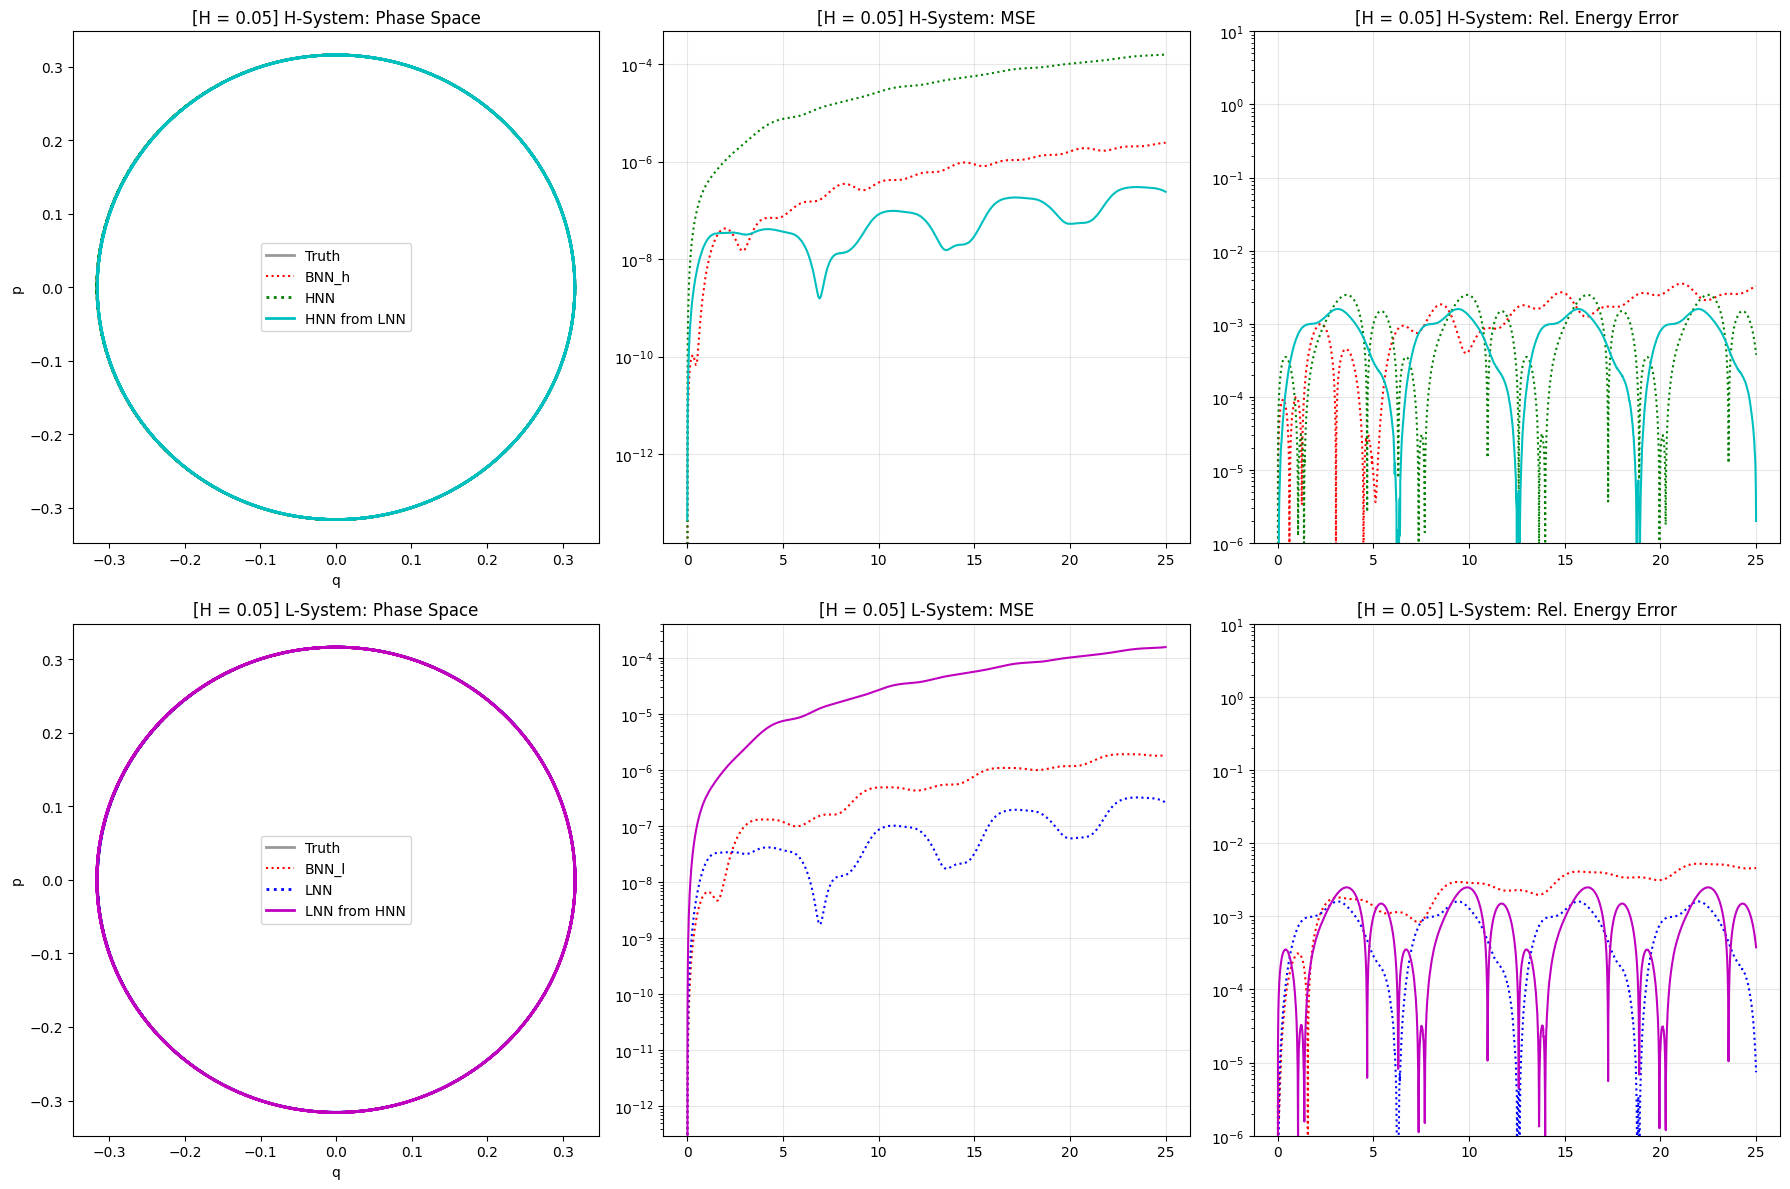

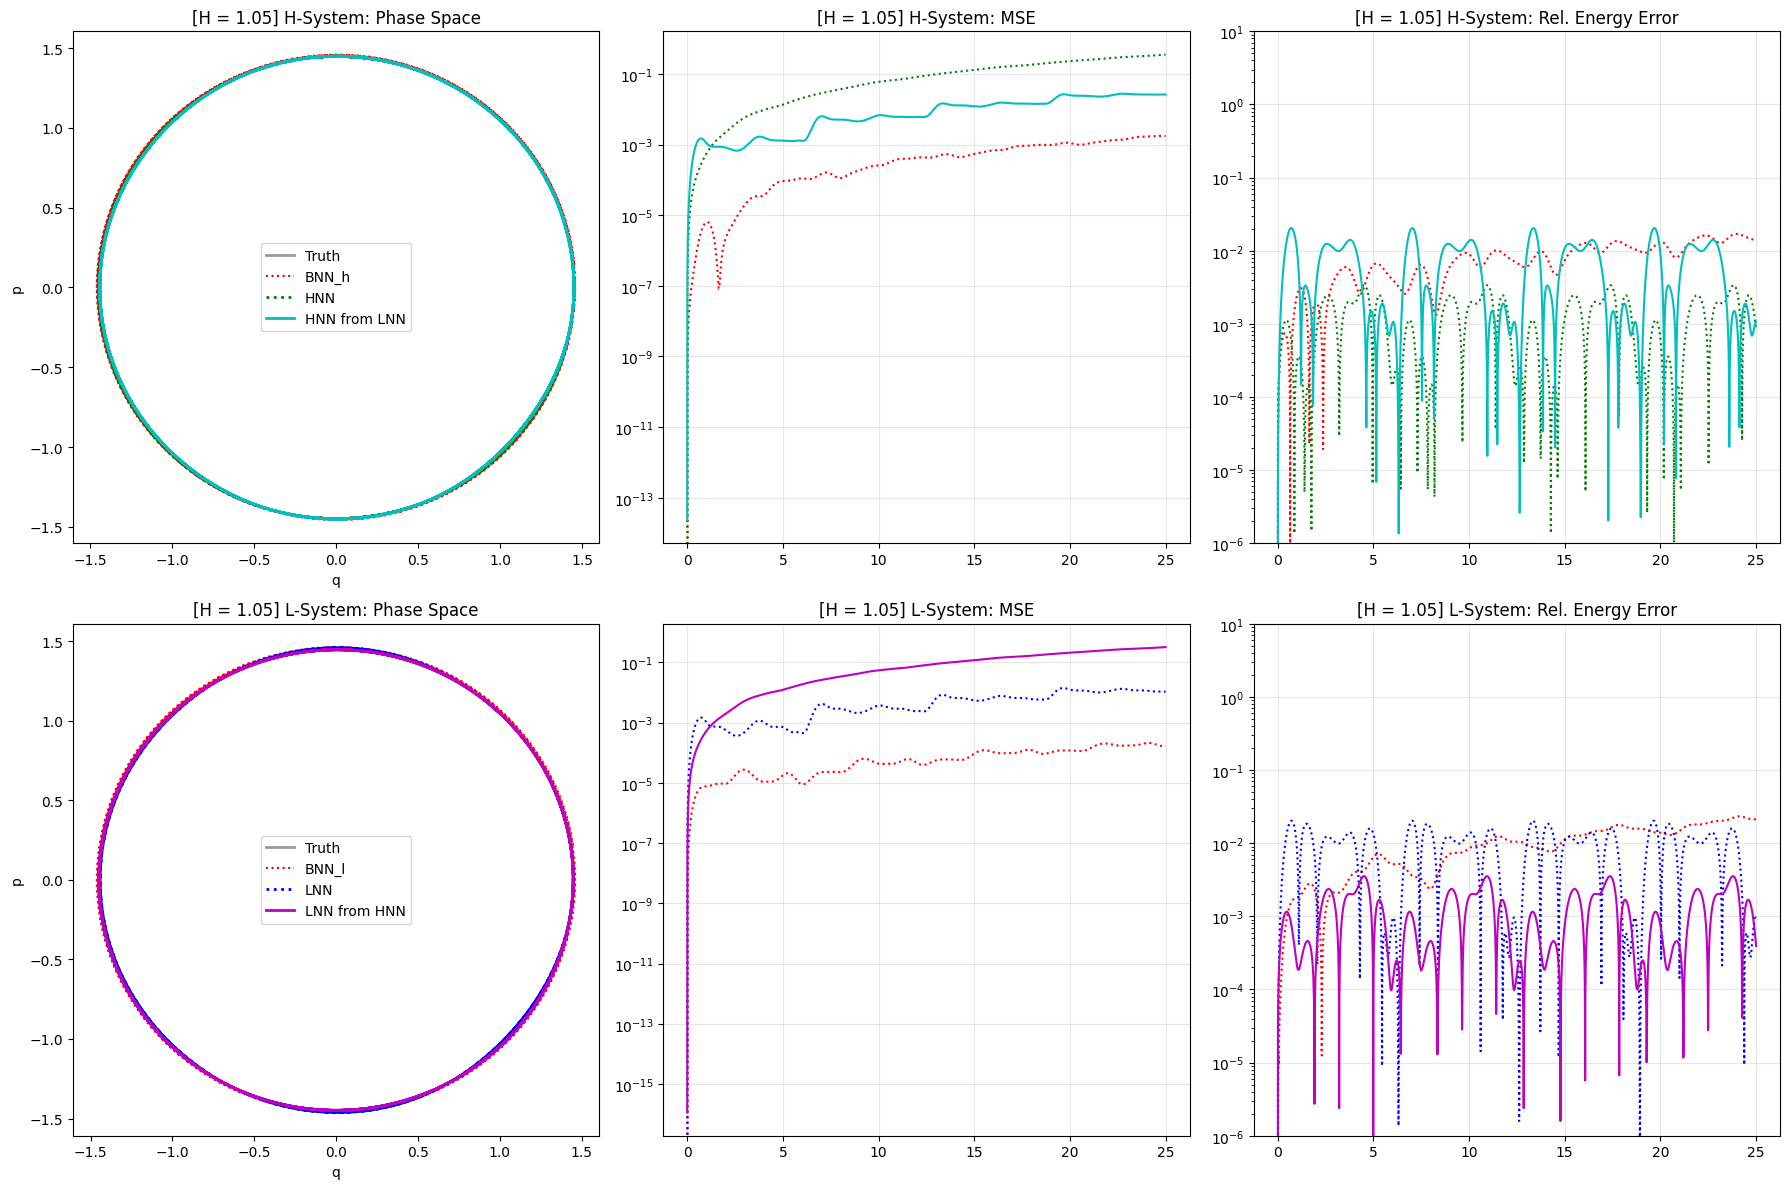

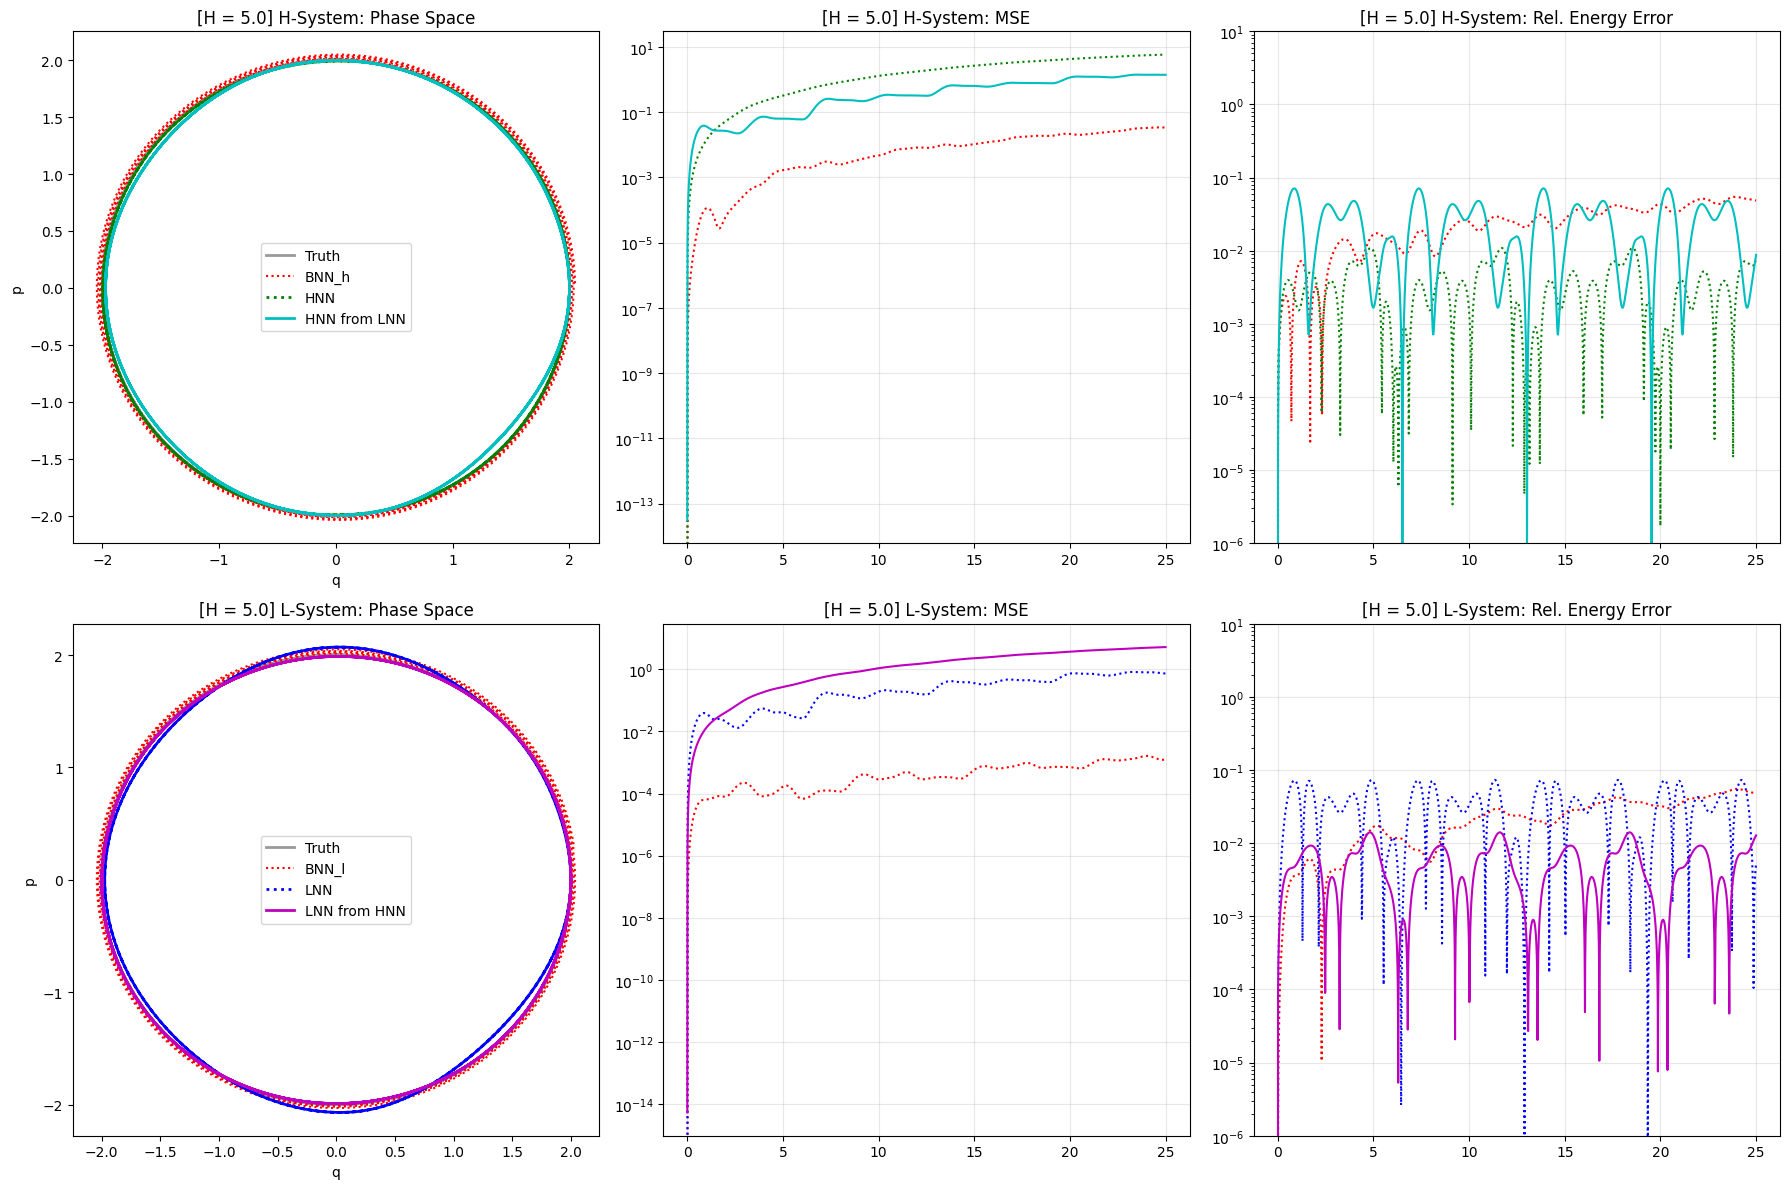

In [9]:
# --- 4. プロット ---

# 1行目: Hamiltonian Comparison
fig = plt.figure(figsize=(18, 15))
gs = gridspec.GridSpec(4, 6, figure=fig) 
'''
for idx_plot in range(10):
    ax1 = fig.add_subplot(gs[0, 0:2]) # Phase Space
    ax2 = fig.add_subplot(gs[0, 2:4]) # MSE
    ax3 = fig.add_subplot(gs[0, 4:6]) # Energy

    # 1-1. Phase Space
    ax1.plot(q_true[idx_plot], p_true[idx_plot], 'k-', label='Ground Truth', lw=2, alpha=0.5)
    ax1.plot(q_bnn_h[idx_plot], p_bnn_h[idx_plot], 'r:', label='Baseline NN_h', lw=1)
    ax1.plot(q_hnn[idx_plot], p_hnn[idx_plot], 'g:', label='HNN (Direct)', lw=1.5)
    ax1.plot(q_hnn_from_lnn[idx_plot], p_hnn_from_lnn[idx_plot], 'c-', label='HNN from LNN', lw=2)
    ax1.set_title(f'Hamiltonian : Phase Space (Traj {idx_plot})')
    ax1.set_xlabel('q')
    ax1.set_ylabel('p')
    ax1.legend()

    # 1-2. MSE (Single Trajectory)
    ax2.plot(t_eval, mse_bnn_h_traj[idx_plot], 'r:', label='Baseline NN_h')
    ax2.plot(t_eval, mse_hnn_traj[idx_plot], 'g:', label='HNN (Direct)')
    ax2.plot(t_eval, mse_hnn_from_lnn_traj[idx_plot], 'c-', label='HNN from LNN')
    ax2.set_title(f'Hamiltonian : MSE (Traj {idx_plot})')
    ax2.set_xlabel('Time')
    ax2.set_yscale('log')
    ax2.set_ylim(1e-8, 1e-0)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 1-3. Total Energy (Single Trajectory)
    ax3.plot(t_eval, E_true[idx_plot], 'k-', label='Truth', lw=2, alpha=0.5)
    ax3.plot(t_eval, E_bnn_h[idx_plot], 'r:', label='Baseline NN_h')
    ax3.plot(t_eval, E_hnn[idx_plot], 'g:', label='HNN (Direct)')
    ax3.plot(t_eval, E_hnn_from_lnn[idx_plot], 'c-', label='HNN from LNN')
    ax3.set_title(f'Hamiltonian : Total Energy (Traj {idx_plot})')
    ax3.set_xlabel('Time')
    ax3.legend()
    ax3.grid(True, alpha=0.3)


    # ==========================================
    # 2行目: Lagrangian Level Comparison
    # (LNN vs LNN from HNN)
    # ==========================================
    ax4 = fig.add_subplot(gs[1, 0:2])
    ax5 = fig.add_subplot(gs[1, 2:4])
    ax6 = fig.add_subplot(gs[1, 4:6])

    # 2-1. Phase Space
    ax4.plot(q_true[idx_plot], p_true[idx_plot], 'k-', label='Ground Truth', lw=2, alpha=0.5)
    ax4.plot(q_bnn_l[idx_plot], p_bnn_l[idx_plot], 'r:', label='Baseline NN_l', lw=1)
    ax4.plot(q_lnn[idx_plot], p_lnn[idx_plot], 'b:', label='LNN (Direct)', lw=1.5)
    ax4.plot(q_lnn_from_hnn[idx_plot], p_lnn_from_hnn[idx_plot], 'm-', label='LNN from HNN', lw=2)
    ax4.set_title(f'Lagrangian : Phase Space (Traj {idx_plot})')
    ax4.set_xlabel('q')
    ax4.set_ylabel('p')
    ax4.legend()

    # 2-2. MSE (Single Trajectory)
    ax5.plot(t_eval, mse_bnn_l_traj[idx_plot], 'r--', label='Baseline NN_l')
    ax5.plot(t_eval, mse_lnn_traj[idx_plot], 'b:', label='LNN (Direct)')
    ax5.plot(t_eval, mse_lnn_from_hnn_traj[idx_plot], 'm-', label='LNN from HNN')
    ax5.set_title(f'Lagrangian : MSE (Traj {idx_plot})')
    ax5.set_xlabel('Time')
    ax5.set_yscale('log')
    ax5.set_ylim(1e-8, 1e-0)
    ax5.legend()
    ax5.grid(True, alpha=0.3)

    # 2-3. Total Energy (Single Trajectory)
    ax6.plot(t_eval, E_true[idx_plot], 'k-', label='Truth', lw=2, alpha=0.5)
    ax6.plot(t_eval, E_bnn_l[idx_plot], 'r:', label='Baseline NN_l')
    ax6.plot(t_eval, E_lnn[idx_plot], 'b:', label='LNN (Direct)')
    ax6.plot(t_eval, E_lnn_from_hnn[idx_plot], 'm-', label='LNN from HNN')
    ax6.set_title(f'Lagrangian : Total Energy (Traj {idx_plot})')
    ax6.set_xlabel('Time')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
'''
    
    

# 3行目: 平均MSE
fig = plt.figure(figsize=(18, 15))
ax7 = fig.add_subplot(gs[2, 0:3]) # Hamiltonian Level Average
ax8 = fig.add_subplot(gs[2, 3:6]) # Lagrangian Level Average

# 3-1. Hamiltonian Comparison Average
ax7.plot(t_eval, mse_bnn_h_mean, 'r:', label='Baseline NN_h', lw=1)
ax7.plot(t_eval, mse_hnn_mean, 'g:', label='HNN (Direct)', lw=1.5)
ax7.plot(t_eval, mse_hnn_from_lnn_mean, 'c-', label='HNN from LNN', lw=2)
ax7.set_title('Average MSE')
ax7.set_xlabel('Time')
ax7.set_ylabel('MSE')
ax7.set_yscale('log')
ax7.set_ylim(1e-8, 1e-0)
ax7.legend()
ax7.grid(True, which="both", ls="-", alpha=0.3)

# 3-2. Lagrangian Comparison Average
ax8.plot(t_eval, mse_bnn_l_mean, 'r:', label='Baseline NN_l', lw=1)
ax8.plot(t_eval, mse_lnn_mean, 'b:', label='LNN (Direct)', lw=1.5)
ax8.plot(t_eval, mse_lnn_from_hnn_mean, 'm-', label='LNN from HNN', lw=2)
ax8.set_title('Average MSE')
ax8.set_xlabel('Time')
ax8.set_ylabel('MSE')
ax8.set_yscale('log')
ax8.set_ylim(1e-8, 1e-0)
ax8.legend()
ax8.grid(True, which="both", ls="-", alpha=0.3)

# 平均エネルギー相対誤差 (Relative Energy Error) 
ax9 = fig.add_subplot(gs[3, 0:3]) # HNN系
ax10 = fig.add_subplot(gs[3, 3:6]) # LNN系
# 4-1. HNN System Average Energy Error
ax9.plot(t_eval, err_energy_bnn_h, 'r:', label='Baseline NN_h', lw=1)
ax9.plot(t_eval, err_energy_hnn, 'g:', label='HNN (Direct)', lw=1.5)
ax9.plot(t_eval, err_energy_hnn_from_lnn, 'c-', label='HNN from LNN', lw=2)
ax9.set_title('Average Relative Energy Error (Hamiltonian)')
ax9.set_xlabel('Time')
ax9.set_ylabel('Rel. Error')
ax9.set_yscale('log')
ax9.set_ylim(1e-6, 1e0) 
ax9.legend()
ax9.grid(True, which="both", ls="-", alpha=0.3)

# 4-2. LNN System Average Energy Error
ax10.plot(t_eval, err_energy_bnn_l, 'r:', label='Baseline NN_l', lw=1)
ax10.plot(t_eval, err_energy_lnn, 'b:', label='LNN (Direct)', lw=1.5)
ax10.plot(t_eval, err_energy_lnn_from_hnn, 'm-', label='LNN from HNN', lw=2)
ax10.set_title('Average Relative Energy Error (Lagrangian)')
ax10.set_xlabel('Time')
ax10.set_ylabel('Rel. Error')
ax10.set_yscale('log')
ax10.set_ylim(1e-6, 1e0)
ax10.legend()
ax10.grid(True, which="both", ls="-", alpha=0.3)



#以下はextrapolation
num_total_traj = q_true.shape[0]
extrap_indices = range(N_interp, num_total_traj)

for idx in extrap_indices:
    if idx == 10:
        H = 0.05
    elif idx == 11:
        H = 1.05
    elif idx == 12:
        H = 5.00
    
    fig = plt.figure(figsize=(18, 12))
    gs = gridspec.GridSpec(2, 3, figure=fig) # 2行3列 (H系, L系)
    
    # Row 1: Hamiltonian System Comparison
    ax1 = fig.add_subplot(gs[0, 0]) # Phase Space
    ax2 = fig.add_subplot(gs[0, 1]) # MSE
    ax3 = fig.add_subplot(gs[0, 2]) # Relative Energy Error

    # 1-1. Phase Space
    ax1.plot(q_true[idx], p_true[idx], 'k-', label='Truth', lw=2, alpha=0.4)
    ax1.plot(q_bnn_h[idx], p_bnn_h[idx], 'r:', label='BNN_h', lw=1.5)
    ax1.plot(q_hnn[idx], p_hnn[idx], 'g:', label='HNN', lw=2)
    ax1.plot(q_hnn_from_lnn[idx], p_hnn_from_lnn[idx], 'c-', label='HNN from LNN', lw=2)
    ax1.set_title(f'[H = {H}] H-System: Phase Space')
    ax1.set_xlabel('q')
    ax1.set_ylabel('p')
    ax1.legend()

    # 1-2. MSE
    ax2.plot(t_eval, mse_bnn_h_traj[idx], 'r:', label='BNN_h')
    ax2.plot(t_eval, mse_hnn_traj[idx], 'g:', label='HNN')
    ax2.plot(t_eval, mse_hnn_from_lnn_traj[idx], 'c-', label='HNN from LNN')
    ax2.set_title(f'[H = {H}] H-System: MSE')
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3)

    # 1-3. Relative Energy Error
    ax3.plot(t_eval, err_E_bnn_h[idx], 'r:', label='BNN_h')
    ax3.plot(t_eval, err_E_hnn[idx], 'g:', label='HNN')
    ax3.plot(t_eval, err_E_hnn_from_lnn[idx], 'c-', label='HNN from LNN')
    ax3.set_title(f'[H = {H}] H-System: Rel. Energy Error')
    ax3.set_yscale('log')
    ax3.set_ylim(1e-6, 10) # 外挿なので誤差が大きい可能性あり
    ax3.grid(True, alpha=0.3)


    # Row 2: Lagrangian System Comparison
    ax4 = fig.add_subplot(gs[1, 0]) # Phase Space
    ax5 = fig.add_subplot(gs[1, 1]) # MSE
    ax6 = fig.add_subplot(gs[1, 2]) # Relative Energy Error

    # 2-1. Phase Space
    ax4.plot(q_true[idx], p_true[idx], 'k-', label='Truth', lw=2, alpha=0.4)
    ax4.plot(q_bnn_l[idx], p_bnn_l[idx], 'r:', label='BNN_l', lw=1.5)
    ax4.plot(q_lnn[idx], p_lnn[idx], 'b:', label='LNN', lw=2)
    ax4.plot(q_lnn_from_hnn[idx], p_lnn_from_hnn[idx], 'm-', label='LNN from HNN', lw=2)
    ax4.set_title(f'[H = {H}] L-System: Phase Space')
    ax4.set_xlabel('q')
    ax4.set_ylabel('p')
    ax4.legend()

    # 2-2. MSE
    ax5.plot(t_eval, mse_bnn_l_traj[idx], 'r:', label='BNN_l')
    ax5.plot(t_eval, mse_lnn_traj[idx], 'b:', label='LNN')
    ax5.plot(t_eval, mse_lnn_from_hnn_traj[idx], 'm-', label='LNN from HNN')
    ax5.set_title(f'[H = {H}] L-System: MSE')
    ax5.set_yscale('log')
    ax5.grid(True, alpha=0.3)

    # 2-3. Relative Energy Error
    ax6.plot(t_eval, err_E_bnn_l[idx], 'r:', label='BNN_l')
    ax6.plot(t_eval, err_E_lnn[idx], 'b:', label='LNN')
    ax6.plot(t_eval, err_E_lnn_from_hnn[idx], 'm-', label='LNN from HNN')
    ax6.set_title(f'[H = {H}] L-System: Rel. Energy Error')
    ax6.set_yscale('log')
    ax6.set_ylim(1e-6, 10)
    ax6.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()